<h1 align="center" style="color:#8DA9C4;">Computational Intelligence for Optimization - Project</h1>
<h3 align="center" style="color:#8DA9C4;">Group S - Sports League Optimization</h3>

---

### <span style="color:#8DA9C4;">Group Members</span>

<table>
  <thead style="color:#8DA9C4;">
    <tr>
      <th>Name</th>
      <th>Email</th>
      <th>Student ID</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Gustavo Veloso</td>
      <td>20240599@novaims.unl.pt</td>
      <td>20240599</td>
    </tr>
    <tr>
      <td>Leonor Mira</td>
      <td>20240658@novaims.unl.pt</td>
      <td>20240658</td>
    </tr>
    <tr>
      <td>Martim Tavares</td>
      <td>20240508@novaims.unl.pt</td>
      <td>20240508</td>
    </tr>
    <tr>
      <td>Santiago Taylor</td>
      <td>20240542@novaims.unl.pt</td>
      <td>20240542</td>
    </tr>
  </tbody>
</table>



---

<h2 style="color:#8DA9C4;">Notebook</h2>

<p><strong style="color:#8DA9C4;">Description:</strong></p>

<p>
This notebook focuses on the development of an optimization algorithm to create a balanced sports league of 5 teams, using a genetic algorithm.
</p>

<p>Key steps include:</p>

<ul>
  <li><strong style="color:#8DA9C4;">Class Definition:</strong> Creating the data structures to which the GA will be applied.</li>
  <li><strong style="color:#8DA9C4;">Crossover and Mutation:</strong> Develop different crossover and mutation functions, making sure to only produce valid solutions considering problem restrictions.</li>
  <li><strong style="color:#8DA9C4;">GA Creation:</strong> Defining the steps of the GA, as well as the Selection methods used.</li>
  <li><strong style="color:#8DA9C4;">Hyperparameter search:</strong> Creating a hyperparameter search space to test different function and parameter combinations.</li>
  <li><strong style="color:#8DA9C4;">GA Comparisons and Final Selection:</strong> Analysing the different combinations, testing for statistical significance, and choosing a best configuration.</li>
</ul>


---


<a id="toc"></a>

<h2 style="color:#8DA9C4;">Table of Contents</h2>

<ul style="list-style-type:none; padding-left:0;">
  <li><span style="color:#8DA9C4;">1.</span> <a href="#chapter1">Import the Libraries</a></li>
  <li><span style="color:#8DA9C4;">2.</span> <a href="#chapter2">Defining Core Classes</a></li>
  <li><span style="color:#8DA9C4;">3.</span> <a href="#chapter3">Defining Mutation</a></li>
  <li><span style="color:#8DA9C4;">4.</span> <a href="#chapter4">Defining Crossover</a></li>
  <li><span style="color:#8DA9C4;">5.</span> <a href="#chapter5">Selection Algorithm</a></li>
  <li><span style="color:#8DA9C4;">6.</span> <a href="#chapter6">Genetic Algorithm</a></li>
  <ul style="list-style-type:none; padding-left:1em;">
        <li><span style="color:#8DA9C4;">6.1</span> <a href="#chapter6-1">Considering Elitism</a></li>
      </ul>
  <li><span style="color:#8DA9C4;">7.</span> <a href="#chapter7">Grid Search</a></li>
  <li><span style="color:#8DA9C4;">8.</span> <a href="#chapter8">Visualization</a></li>
  
</ul>

---

<h2 id="chapter1" style="color:#8DA9C4;">1. Import the Libraries and Load the Data</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p>In this section, we import the necessary libraries required throughout this notebook.</p>

In [3]:
import sys
sys.path.append('..')

In [ ]:
import random
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pathlib import Path
import pandas as pd
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
from itertools import combinations

from typing import Callable
from copy import deepcopy
from tqdm import tqdm

In [ ]:
# Check if the file exists
players_df = pd.read_csv("players(in).csv", index_col=0)

<h2 id="chapter2" style="color:#8DA9C4;">2. Defining Core Classes</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>


<p>This section defines the core classes that structure the logic of the evolutionary algorithm. These classes encapsulate fundamental concepts such as players, teams, and leagues, enabling modular and reusable management of data and operations throughout the notebook. They will later be used to assign players, apply genetic operators, and evaluate candidate solutions.
</p>

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

<p>The defined classes provide a structured model for the player allocation problem under budget constraints and performance objectives. The main features of each class are described below:</p>

<ul>
  <li><strong style="color:#8DA9C4;">Player:</strong> Represents an individual player with attributes such as name, position, skill level, and salary. Includes methods for comparison and unique identification.</li>
  <li><strong style="color:#8DA9C4;">Team:</strong> Represents a football team and manages the allocation of players by position. Calculates metrics like total salary and average skill, and checks whether the team exceeds the budget.</li>
  <li><strong style="color:#8DA9C4;">League:</strong> Holds a set of teams and applies genetic operations such as crossover and mutation. Evaluates the quality of the solution based on team balance and budget compliance.</li>
</ul>

<p>These abstractions are essential for organizing and efficiently manipulating the data throughout the simulation and optimization process.</p>

</div>


In [ ]:
class Player():

    def __init__(self, player):
        self.name = player["Name"]
        self.position = player["Position"]
        self.skill = player["Skill"]
        self.salary = player["Salary (€M)"]

    # To display the player name and position
    def __repr__(self):
        return f"{self.name} - {self.position}"

    # Equality method to compare two Player objects based on their name and position
    # This is so that despite player objects being different due to different instantiations, they are compared based on name and position
    def __eq__(self, other):
        if not isinstance(other, Player):
            return False
        return self.name == other.name and self.position == other.position

    # Hash method to allow Player objects to be used in sets or as dictionary keys
    def __hash__(self):  
        return hash((self.name, self.position))

In [ ]:
class Team():

    # Inicializes the team with a name and budget
    def __init__(self, name, budget):

        self.budget = budget
        self.name = name
        self.goalkeepers = []
        self.defenders = []
        self.midfielders = []
        self.forwards = []

    # Adds a player to the team based on their position
    def add_player(self, player):
        if player.position == "GK":
            self.goalkeepers.append(player)
        if player.position == "DEF":
            self.defenders.append(player)
        if player.position == "MID":
            self.midfielders.append(player)
        if player.position == "FWD":
            self.forwards.append(player)

    # Calculates the total salary of the team
    def total_salary(self):
        return sum([p.salary for p in self.goalkeepers + self.defenders + self.midfielders + self.forwards])

    # Calculates the average skill of the team
    def average_skill(self):
        return statistics.mean([p.skill for p in self.goalkeepers + self.defenders + self.midfielders + self.forwards])

    # Checks if the team is over budget
    def over_budget(self):
        return sum([p.salary for p in self.goalkeepers + self.defenders + self.midfielders + self.forwards]) > self.budget

In [ ]:
class League():

    # Initializes the league with a crossover and mutation function
    def __init__(self, crossover_function, mutation_function): 
        self.mutation_function = mutation_function
        self.crossover_function = crossover_function
        self.teams = [
            Team("Team 1", 750),
            Team("Team 2", 750),
            Team("Team 3", 750),
            Team("Team 4", 750),
            Team("Team 5", 750)
        ]

    # Checks if the league is valid by ensuring all players are unique (just used to test, not used in algorithm )
    def valid_league(self):
        players = [p for t in self.teams for p in t.goalkeepers + t.defenders + t.midfielders + t.forwards]
        return len(set(players)) == len(players)
    
    # Players are grouped by their positions (easier to do crossover/mutation and maintain valid solutions)
    def player_positions(self):
        player_positions = {
            "GK": [p for t in self.teams for p in t.goalkeepers],
            "DEF": [p for t in self.teams for p in t.defenders],
            "MID": [p for t in self.teams for p in t.midfielders],
            "FWD": [p for t in self.teams for p in t.forwards]
        }
        return player_positions


    # Allocate players to teams from separate position lists
    # Essentially undoes the effects of the function player_positions.
    # These two functions are used back and forth for crossover/mutations and then league creation
    def allocate_players_from_lists(self, goalkeepers, defenders, midfielders, forwards):
        
        # Clear teams
        for team in self.teams:
            team.goalkeepers = []
            team.defenders = []
            team.midfielders = []
            team.forwards = []

        for i, team in enumerate(self.teams):
            team.add_player(goalkeepers[i])
            team.add_player(defenders[i * 2])
            team.add_player(defenders[i * 2 + 1])
            team.add_player(midfielders[i * 2])
            team.add_player(midfielders[i * 2 + 1])
            team.add_player(forwards[i * 2])
            team.add_player(forwards[i * 2 + 1])

    # Allocate players to teams from a list of players (used in conjunction with the above function)
    # Used for creatting teams at the start
    def draft_players(self, players):

        # Separate players by position
        goalkeepers = [p for p in players if p.position == "GK"]
        defenders = [p for p in players if p.position == "DEF"]
        midfielders = [p for p in players if p.position == "MID"]
        forwards = [p for p in players if p.position == "FWD"]

        # Shuffle players in each position
        random.shuffle(goalkeepers)
        random.shuffle(defenders)
        random.shuffle(midfielders)
        random.shuffle(forwards)

        self.allocate_players_from_lists(goalkeepers, defenders, midfielders, forwards)


    def show_teams(self):
        for team in self.teams:
            print(f"\n{team.name}")
            print("──────────────")
            for player in team.goalkeepers + team.defenders + team.midfielders + team.forwards:
                print(f"{player.name} - {player.position}")
        print("──────────────")

    # Fitness function to evaluate the league
    def fitness(self):
        std = statistics.stdev([team.average_skill() for team in self.teams])
        over_budget_count = sum(team.over_budget() for team in self.teams)
        return std + over_budget_count




    # Mutation function to mutate players in the league
    def mutation(self, mut_prob):
        player_positions = self.player_positions()

        self.mutation_function(player_positions["GK"], mut_prob)
        self.mutation_function(player_positions["DEF"], mut_prob)
        self.mutation_function(player_positions["MID"], mut_prob)
        self.mutation_function(player_positions["FWD"], mut_prob)

        mutated_team = League(self.crossover_function, self.mutation_function)
        mutated_team.allocate_players_from_lists(player_positions["GK"], player_positions["DEF"], player_positions["MID"], player_positions["FWD"])

        return mutated_team

    # Crossover function to create new leagues from two parent leagues
    def crossover(self, other_solution):
        parent1_positions = self.player_positions()
        parent2_positions = other_solution.player_positions()

        offspring1_goalkeepers, offspring2_goalkeepers = self.crossover_function(parent1_positions["GK"], parent2_positions["GK"])
        offspring1_defenders, offspring2_defenders = self.crossover_function(parent1_positions["DEF"], parent2_positions["DEF"])
        offspring1_midfielders, offspring2_midfielders = self.crossover_function(parent1_positions["MID"], parent2_positions["MID"])
        offspring1_forwards, offspring2_forwards = self.crossover_function(parent1_positions["FWD"], parent2_positions["FWD"])

        # Create new leagues and allocate players
        offspring1 = League(self.crossover_function, self.mutation_function)
        offspring1.allocate_players_from_lists(offspring1_goalkeepers, offspring1_defenders, offspring1_midfielders, offspring1_forwards)

        offspring2 = League(self.crossover_function, self.mutation_function)
        offspring2.allocate_players_from_lists(offspring2_goalkeepers, offspring2_defenders, offspring2_midfielders, offspring2_forwards)

        return offspring1, offspring2


<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

![League Definition](images/League%20Definition.png)

</div>


<h2 id="chapter3" style="color:#8DA9C4;">3. Defining Mutation</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p>This section implements the mutation operators used to introduce diversity into candidate solutions. Mutation functions apply more abrupt transformations than crossover, modifying team configurations in a way that allows the algorithm to escape local optima and explore new areas of the solution space.</p>


<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

<p>The mutation operators modify team line-ups in various ways, helping the genetic algorithm to search the solution space more thoroughly. The defined mutations include:</p>

<ul>
  <li><strong style="color:#8DA9C4;">Swap Mutation:</strong> Randomly selects two player positions within a team and swaps their places, preserving team size and composition.</li>
  <li><strong style="color:#8DA9C4;">Shift Mutation:</strong> Selects a random subsequence of players within the team and performs a right circular shift — the last player in the selected range moves to the first position, and all others shift one place to the right.</li>
  <li><strong style="color:#8DA9C4;">Inversion Mutation:</strong> Selects a subsequence of players and reverses their order, introducing larger reordering effects.</li>
</ul>

<p>These mutation strategies ensure both small perturbations and larger reconfigurations, fostering a balance between exploration and exploitation in the evolutionary process.</p>

</div>


In [ ]:
def shift_mutation(repr, mut_prob):

    new_representation = deepcopy(repr) # To avoid modifying the original representation

    # Apply mutation based on the mutation probability
    if random.random() < mut_prob:
        first_idx = random.randint(0, len(repr) - 1)
        second_idx = first_idx

        # Ensure the second index is different from the first
        while second_idx == first_idx:
            second_idx = random.randint(0, len(repr) - 1)

        first_idx, second_idx = min(first_idx, second_idx), max(first_idx, second_idx)

        sub = new_representation[first_idx:second_idx + 1]  # Extract the sublist between the two indices
        sub = [sub[-1]] + sub[:-1]                          # Perform a shift mutation by moving the last element of the sublist to the front
        new_representation[first_idx:second_idx + 1] = sub  # Replace the original sublist

    return new_representation

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

![Shift Mutation](images/shift%20Mutation.png)

</div>

In [ ]:
def invertion_mutation(repr, mut_prob):

    new_representation = deepcopy(repr)
    
    if random.random() < mut_prob:
        first_idx = random.randint(0, len(repr) - 1)
        second_idx = first_idx

        while second_idx == first_idx:
            second_idx = random.randint(0, len(repr) - 1)

        first_idx, second_idx = min(first_idx, second_idx), max(first_idx, second_idx)

        # Perform inversion mutation by reversing the sublist between the two indices
        new_representation[first_idx:second_idx + 1] = reversed(new_representation[first_idx:second_idx + 1])

    return new_representation


<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">


![Inversion Mutation](images/invertion%20mutation.png)

</div>

In [ ]:
def swap_mutation(repr, mut_prob):

    new_representation = deepcopy(repr)

    if random.random() < mut_prob:
        first_idx = random.randint(0, len(repr) - 1)
        second_idx = first_idx
        while second_idx == first_idx:
            second_idx = random.randint(0, len(repr) - 1)

        # Swap the elements at the two indices
        new_representation[first_idx] = repr[second_idx]
        new_representation[second_idx] = repr[first_idx]

        return new_representation

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">


![Swap Mutation](images/swap%20mutation.png)

</div>

<h2 id="chapter4" style="color:#8DA9C4;">4. Defining Crossover</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p>This section defines the crossover operators used to generate offspring by combining information from two parent solutions. Crossover plays a crucial role in genetic algorithms, enabling the inheritance of useful genetic traits and the exploration of new combinations within the solution space.</p>


<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

<p>Two crossover strategies are implemented, both tailored for permutation-based representations, where each element (e.g., a player or team assignment) must appear exactly once in a valid solution:</p>

<ul>
  <li><strong style="color:#8DA9C4;">Cycle Crossover:</strong> Preserves cycles of values between two parents by identifying and swapping element positions in a structured way. This ensures that the offspring inherit consistent positional relationships without introducing duplicates.</li>

  <li><strong style="color:#8DA9C4;">Swap Crossover:</strong> Selects one or more random positions and swaps the corresponding elements between parents. This introduces controlled randomness while preserving the uniqueness of elements in the offspring.</li>
</ul>

<p>Both methods are designed to maintain valid permutations and avoid duplicate values.</p>

</div>



In [ ]:
def swap_crossover(parent1_repr: str | list, parent2_repr: str | list):

    size = len(parent1_repr)
    offspring1_repr = parent1_repr.copy()
    offspring2_repr = parent1_repr.copy()

    # Helper function
    def swap(parent1_repr, parent2_repr):
        offspring_repr = parent1_repr.copy()
        
        # Randomly choose 1 position to perform a swap
        swap_positions = random.sample(range(size), 1)

        for pos in swap_positions:
            val_from_p2 = parent2_repr[pos]                     # Get the value from parent2 at the chosen position
            index_in_child = offspring_repr.index(val_from_p2)  # Find the index of that value in the offspring representation

            # Swap the values at the chosen position and the index in the offspring
            offspring_repr[pos], offspring_repr[index_in_child] = offspring_repr[index_in_child], offspring_repr[pos]

        return offspring_repr

# Generate two offspring representations by swapping values between the two parents
# Note: For each offspring, we will run the swap function and get different indexes to swap betwreen the two offspring
    offspring1_repr = swap(parent1_repr=parent1_repr, parent2_repr=parent2_repr)
    offspring2_repr = swap(parent1_repr=parent2_repr, parent2_repr=parent1_repr)

    return offspring1_repr, offspring2_repr

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

![Swap Crossover](images/swap_crossover.png)

</div>

In [ ]:
def cycle_crossover(parent1_repr, parent2_repr):
    initial_random_idx = random.randint(0, len(parent1_repr) -1)

    cycle_idxs = [initial_random_idx]
    current_cycle_idx = initial_random_idx

    while True:
        value_parent2 = parent2_repr[current_cycle_idx]

        next_cycle_idx = parent1_repr.index(value_parent2)

        if next_cycle_idx in cycle_idxs:
            break

        cycle_idxs.append(next_cycle_idx)
        current_cycle_idx = next_cycle_idx

    offspring1_repr = []
    offspring2_repr = []

    for idx in range(len(parent1_repr)):
        if idx in cycle_idxs:
            offspring1_repr.append(parent2_repr[idx])
            offspring2_repr.append(parent1_repr[idx])

        else:
            offspring1_repr.append(parent1_repr[idx])
            offspring2_repr.append(parent2_repr[idx])

    if isinstance(parent1_repr, str) and isinstance(parent2_repr, str):
        offspring1_repr = "". join(offspring1_repr)
        offspring2_repr = "". join(offspring2_repr)

    return offspring1_repr, offspring2_repr

<h2 id="chapter5" style="color:#8DA9C4;">5. Selection Algorithm</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p>This section defines the selection mechanisms that determine which individuals are chosen to reproduce and contribute to the next generation. Selection is crucial in guiding the genetic algorithm toward optimal solutions by favoring fitter individuals, while still maintaining diversity in the population.</p>


<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

<p>Two selection strategies are implemented:</p>

<ul>
  <li><strong style="color:#8DA9C4;">Tournament Selection</strong> </li>

  <li><strong style="color:#8DA9C4;">Fitness-Proportionate Selection (Roulette Wheel)</strong></li>
</ul>

<p>Both approaches promote the survival of fitter individuals, but in different ways: tournament selection introduces more deterministic pressure, while fitness-proportionate selection maintains a smoother probabilistic balance.</p>

</div>


In [ ]:
def tournament_selection(population: list[League], maximization: bool, tournament_size: int = 4):

    tournament = random.sample(population, tournament_size)
    return deepcopy(get_best_ind(tournament, maximization))

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

![tournament Selection](images/tournament%20Selection.png)

</div>

In [ ]:
def fitness_proportionate_selection(population: list[League], maximization: bool):
    # total_fitness = sum([ind.fitness() for ind in population])

    if maximization:
        fitness_values = [ind.fitness() for ind in population]
    else:
        # Minimization: Use the inverse of the fitness value
        # Lower fitness should have higher probability of being selected
        fitness_values = [1 / ind.fitness() for ind in population]

    total_fitness = sum(fitness_values)
    # Generate random number between 0 and total
    random_nr = random.uniform(0, total_fitness)
    box_boundary = 0
    # For each individual, check if random number is inside the individual's "box"
    for ind_idx, ind in enumerate(population):
        box_boundary += fitness_values[ind_idx]
        if random_nr <= box_boundary:
            return deepcopy(ind)

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

![roulette](images/roulette.png)

</div>

<h2 id="chapter6" style="color:#8DA9C4;">6. Genetic Algorithm</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p>This section implements a customizable genetic algorithm that evolves a population of solutions over multiple generations. Key components include:</p>

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

<ul>
  <li><strong style="color:#8DA9C4;">Selection:</strong> Configurable via external strategies such as tournament or fitness-proportionate selection.</li>
  <li><strong style="color:#8DA9C4;">Crossover:</strong> Applied with a probability (<code>xo_prob</code>) to generate new individuals by recombining parents.</li>
  <li><strong style="color:#8DA9C4;">Mutation:</strong> Introduces variation in offspring based on a defined mutation rate (<code>mut_prob</code>).</li>
  <li><strong style="color:#8DA9C4;">Elitism (optional):</strong> When enabled, the best individual of each generation is preserved to ensure solution quality is not lost.</li>
  <li><strong style="color:#8DA9C4;">Maximization/Minimization:</strong> Controlled via the <code>maximization</code> flag to adapt to different objective types.</li>
</ul>

<p>The algorithm records the best fitness of each generation, allowing for performance tracking over time.</p>


</div>


In [ ]:
def get_best_ind(population: list[League], maximization: bool):
    fitness_list = [ind.fitness() for ind in population]
    if maximization:
        return population[fitness_list.index(max(fitness_list))]
    else:
        return population[fitness_list.index(min(fitness_list))]

In [ ]:
def genetic_algorithm(
    initial_population: list[League],   # MUDAR ISTO PARA LISTA DE SOLUTION
    max_gen: int,
    selection_algorithm: Callable,
    maximization: bool = False,
    xo_prob: float = 0.9,
    mut_prob: float = 0.1,
    elitism: bool = True,
    verbose: bool = False,
    ):

    population = initial_population
    fitness_list = []

    for gen in range(1, max_gen + 1):
        if verbose:
            print(f"------------ Generation {gen} ------------")

        new_population = []

        if elitism:
            new_population.append(deepcopy(get_best_ind(population, maximization)))

        while len(new_population) < len(population):
            first_ind = selection_algorithm(population=population, maximization=maximization)

            second_ind = selection_algorithm(population=population, maximization=maximization)

            if verbose:
                print(f"Selected Individuals: \n{first_ind}\n{second_ind}")

            if random.random() < xo_prob:
                offspring1, offspring2 = first_ind.crossover(second_ind)
                if verbose:
                    print("Applied Crossover")
            else:
                offspring1, offspring2 = deepcopy(first_ind), deepcopy(second_ind)
                if verbose:
                    print("Not Applied Replication")

            if verbose:
                print(f"Offspring 1: {offspring1}\n{offspring2}")

            first_new_ind = offspring1.mutation(mut_prob)
            new_population.append(first_new_ind)

            if verbose:
                print(f"First mutated individual: {first_new_ind}")

            if len(new_population) < len(population):
                second_new_ind = offspring2.mutation(mut_prob)
                new_population.append(second_new_ind)
                if verbose:
                    print(f"Second mutated individual: {second_new_ind}")

        population = new_population
        fitness_list.append(get_best_ind(population, maximization).fitness())

        if verbose:
            print(f"Final Best Individual in Generation: {get_best_ind(population, maximization)}")

    return get_best_ind(population, maximization), fitness_list


<h2 id="chapter6-1" style="color:#8DA9C4;">6.1 Considering Elitism</h2>
<p>Considering that elitism almost always provides less consistent results, before performing a grid search for best parameters, the impact of elitism will be studied to determine whether or not it is owrth including in the grid search.</p>

Best solution: (<__main__.League object at 0x000001BD5976B440>, [0.35571141708538767, 0.35571141708538767, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.119522860

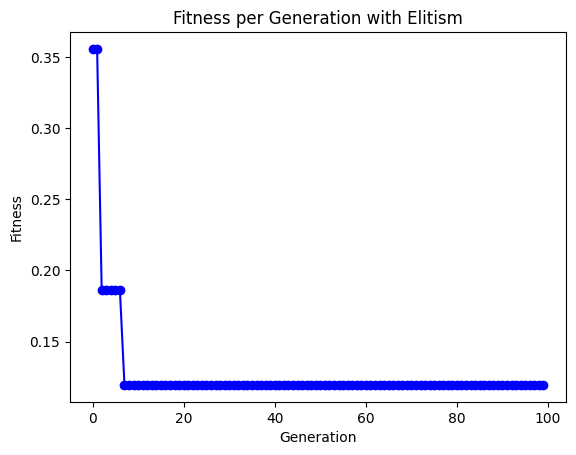

In [ ]:
SEED = 40
random.seed(SEED)
np.random.seed(SEED)

POP_SIZE = 50
initial_population = []


for _ in range(POP_SIZE):
    players = [Player(row) for _, row in players_df.iterrows()]
    league = League(cycle_crossover, shift_mutation)
    league.draft_players(players)
    initial_population.append(league)

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=100,
    selection_algorithm=fitness_proportionate_selection,
    maximization=False,
    mut_prob=0.1,
    verbose=False,
    elitism=True
)

print("Best solution:", best_solution)
print("Fitness:", best_solution[0].fitness())
print("Fitness List:", best_solution[1])


# Create a line plot
plt.plot(best_solution[1], marker='o', linestyle='-', color='b')

# Optional: Add labels and title
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness per Generation with Elitism')

# Show the plot
plt.show()

Best solution: (<__main__.League object at 0x000001BD5976AF30>, [0.2927700218845634, 0.11952286093343596, 0.2927700218845634, 0.2927700218845634, 0.3257644071711802, 0.25555062599997586, 0.21189138534558866, 0.25555062599997586, 0.25555062599997586, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.25555062599997586, 0.25555062599997586, 0.25555062599997586, 0.25555062599997586, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564921592871917, 0.1564

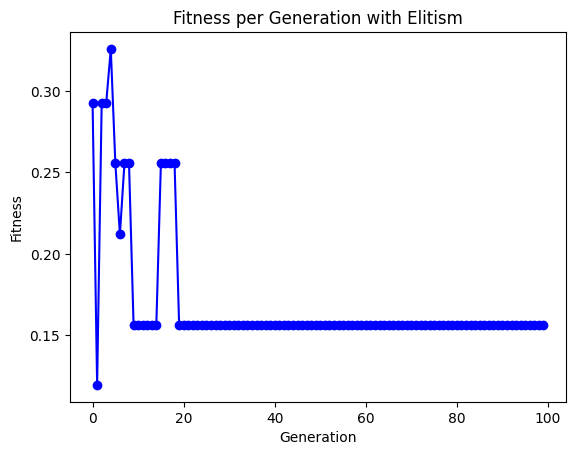

In [ ]:
SEED = 26
random.seed(SEED)
np.random.seed(SEED)

POP_SIZE = 50
initial_population = []


for _ in range(POP_SIZE):
    players = [Player(row) for _, row in players_df.iterrows()]
    league = League(cycle_crossover, shift_mutation)
    league.draft_players(players)
    initial_population.append(league)

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=100,
    selection_algorithm=fitness_proportionate_selection,
    maximization=False,
    mut_prob=0.1,
    verbose=False,
    elitism=False
)

print("Best solution:", best_solution)
print("Fitness:", best_solution[0].fitness())
print("Fitness List:", best_solution[1])


# Create a line plot
plt.plot(best_solution[1], marker='o', linestyle='-', color='b')

# Optional: Add labels and title
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness per Generation without Elitism')

# Show the plot
plt.show()

As can be seen, the lack of elitism leads to sporadic fitness, as well as the possibility of worsening population fitness. For this reason, Elitism will always be considered as True for the grid search.

<h2 id="chapter7" style="color:#8DA9C4;">7. Grid Search</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p>This section explores the systematic evaluation of different genetic algorithm configurations through a grid search. By combining multiple operator choices and parameter values, the goal was to assess their impact on solution quality and algorithm behavior.</p>

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

<ul>
  <li><strong style="color:#8DA9C4;">Operators Tested:</strong> Combinations of selection (e.g., tournament), crossover (e.g., swap), and mutation functions (e.g., swap mutation) were evaluated.</li>
  <li><strong style="color:#8DA9C4;">Key Parameters:</strong> Included crossover and mutation probabilities, as well as tournament size for selection pressure tuning.</li>
  <li><strong style="color:#8DA9C4;">Parallel Execution:</strong> To reduce runtime, the grid search was distributed across four machines and results were merged into a unified dataset.</li>
  <li><strong style="color:#8DA9C4;">Evaluation Strategy:</strong> Each configuration was executed 30 times to account for stochastic variability, using a population of 50 over 100 generations.</li>
  <li><strong style="color:#8DA9C4;">Statistical Testing:</strong> The Wilcoxon signed-rank test was used to compare configurations; no statistically significant performance differences were found.</li>
</ul>
</div>


This cell is commented out due to its high computational cost.

In [ ]:
'''
SEED = 40
random.seed(SEED)
np.random.seed(SEED)

POP_SIZE = 50
GENERATIONS = 100

grid_params = {
    "crossover": [
        {"function": cycle_crossover, "xo_prob": 0.2},   # SANTIAGO
        #{"function": cycle_crossover, "xo_prob": 0.9},  #LEONOR
        #{"function": swap_crossover, "xo_prob": 0.2},   # GUSTAVO
        #{"function": swap_crossover, "xo_prob": 0.9}    # MARTIM
    ],
    "mutation": [
        {"function": shift_mutation,"mut_prob": 0.1},
        {"function": shift_mutation,"mut_prob": 0.5},
        {"function": invertion_mutation,"mut_prob": 0.1},
        {"function": invertion_mutation,"mut_prob": 0.5},
        {"function": swap_mutation,"mut_prob": 0.1},
        {"function": swap_mutation,"mut_prob": 0.5}
    ],
    "selection": [
        {"function": fitness_proportionate_selection, "maximization": False},
        {"function": tournament_selection, "tournament_size": 3, "maximization": False},
        {"function": tournament_selection, "tournament_size": 6, "maximization": False}
    ]
}

fitness_dfs = {}

grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["selection"]))             

print(f"Number of configs: {len(grid)}")


for crossover_cfg, mutation_cfg, selection_cfg in tqdm(grid):
            

    # Create empty dataframe for each configuration
    # Columns have the fitness in each generation, rows will have results for each run
    df = pd.DataFrame(columns=range(GENERATIONS)) # Shape will be 30 x 200

    # Get crossover and mutation functions and probabilities from the grid
    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]
    selection_function = selection_cfg["function"]
    if selection_function == tournament_selection:
        tournament_size = selection_cfg["tournament_size"]
    maximization = selection_cfg["maximization"]

    config_results = []

    for run_nr in tqdm(range(30)):



        initial_population = []

        for _ in range(POP_SIZE):
            players = [Player(row) for _, row in players_df.iterrows()]
            league = League(crossover_function, mutation_function)
            league.draft_players(players)
            initial_population.append(league)

        _, fitness_over_gens = genetic_algorithm(
            initial_population=initial_population,
            max_gen=GENERATIONS,
            selection_algorithm=selection_function,
            maximization=False,
            mut_prob=mut_prob,
            verbose=False
        )
        config_results.append(fitness_over_gens)
        df.loc[run_nr] = fitness_over_gens

        selection_name = selection_function.__name__
        if selection_function == tournament_selection:
            selection_name += f"(k={selection_cfg['tournament_size']})"

        config_label = (
          f"{crossover_function.__name__}{xo_prob}_"
          f"{mutation_function.__name__}{mut_prob}_"
          f"{selection_name}"_Elitism=True

        )

    df.to_csv(f"results_santi/fitness_{config_label}.csv", index=False)   # SANTIAGO
    #df.to_csv(f"results_leonor/fitness_{config_label}.csv", index=False)   # LEONOR
    #df.to_csv(f"results_gustavo/fitness_{config_label}.csv", index=False)    #GUSTAVO
    #df.to_csv(f"results_martim/fitness_{config_label}.csv", index=False)   #MARTIM

    fitness_dfs[config_label] = df
'''


'\nSEED = 40\nrandom.seed(SEED)\nnp.random.seed(SEED)\n\nPOP_SIZE = 50\nGENERATIONS = 100\n\ngrid_params = {\n    "crossover": [\n        {"function": cycle_crossover, "xo_prob": 0.2},   # SANTI\n        #{"function": cycle_crossover, "xo_prob": 0.9},  #LEONOR\n        #{"function": swap_crossover, "xo_prob": 0.2},   # GUSTAVO\n        #{"function": swap_crossover, "xo_prob": 0.9}    # MARTIM\n    ],\n    "mutation": [\n        {"function": shift_mutation,"mut_prob": 0.1},\n        {"function": shift_mutation,"mut_prob": 0.5},\n        {"function": invertion_mutation,"mut_prob": 0.1},\n        {"function": invertion_mutation,"mut_prob": 0.5},\n        {"function": swap_mutation,"mut_prob": 0.1},\n        {"function": swap_mutation,"mut_prob": 0.5}\n    ],\n    "selection": [\n        {"function": fitness_proportionate_selection, "maximization": False},\n        {"function": tournament_selection, "tournament_size": 3, "maximization": False},\n        {"function": tournament_selection, "

In [ ]:
fitness_dfs = {}

base_path = Path().absolute()  # update this with your actual path

for folder in base_path.glob("results_*"):
    #person = folder.name.replace("results_", "")
    
    for csv_file in folder.glob("*.csv"):
        config_name = csv_file.stem      # e.g., cycle_swap_elitism=True
        runs_df = pd.read_csv(csv_file)  # shape: 30 x 200

        # Use person+config as the key if needed
        key = f"{config_name}"
        fitness_dfs[key] = runs_df

In [ ]:
fitness_dfs["fitness_cycle_crossover0.2_invertion_mutation0.1_fitness_proportionate_selection_elitism=True"]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.383326,0.383326,0.383326,0.383326,0.383326,0.255551,0.255551,0.255551,0.255551,0.255551,...,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891
1,0.234738,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888,...,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888
2,0.292770,0.292770,0.292770,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,...,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891
3,0.498979,0.234738,0.234738,0.211891,0.186263,0.186263,0.119523,0.119523,0.119523,0.119523,...,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523
4,0.341067,0.325764,0.325764,0.325764,0.325764,0.234738,0.234738,0.234738,0.211891,0.211891,...,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891,0.211891
5,0.274791,0.274791,0.274791,0.186263,0.156492,0.156492,0.156492,0.156492,0.156492,0.156492,...,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523
6,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,...,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523
7,0.186263,0.186263,0.186263,0.186263,0.156492,0.156492,0.156492,0.156492,0.119523,0.119523,...,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523,0.119523
8,0.528764,0.467298,0.467298,0.467298,0.467298,0.444926,0.325764,0.234738,0.234738,0.211891,...,0.156492,0.156492,0.156492,0.156492,0.156492,0.156492,0.156492,0.156492,0.156492,0.156492
9,0.325764,0.325764,0.325764,0.255551,0.255551,0.255551,0.063888,0.063888,0.063888,0.063888,...,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888,0.063888


<h2 id="chapter8" style="color:#8DA9C4;">8. Visualization</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p>In this section, we visualize the outcomes and behavior of the genetic algorithm across generations. These plots help interpret the model's convergence and provide insights into the effectiveness of the evolutionary process.</p>

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

<p>Common visualizations include:</p>

<ul>
  <li><strong style="color:#8DA9C4;">Fitness Evolution:</strong> A line plot showing how the best, worst, or average fitness scores change across generations. This indicates whether the population is improving over time.</li>
  
  <li><strong style="color:#8DA9C4;">Team Composition:</strong> Bar charts or tables to display the final configuration of players per team, helping to assess balance, diversity, and budget use.</li>
  
  <li><strong style="color:#8DA9C4;">Selection Distribution:</strong> (Optional) Histogram or pie chart to show which individuals were selected more often, indicating selection pressure or bias.</li>
</ul>

<p>These graphical summaries support both debugging and result interpretation, making the optimization process more transparent and easier to evaluate.</p>

</div>


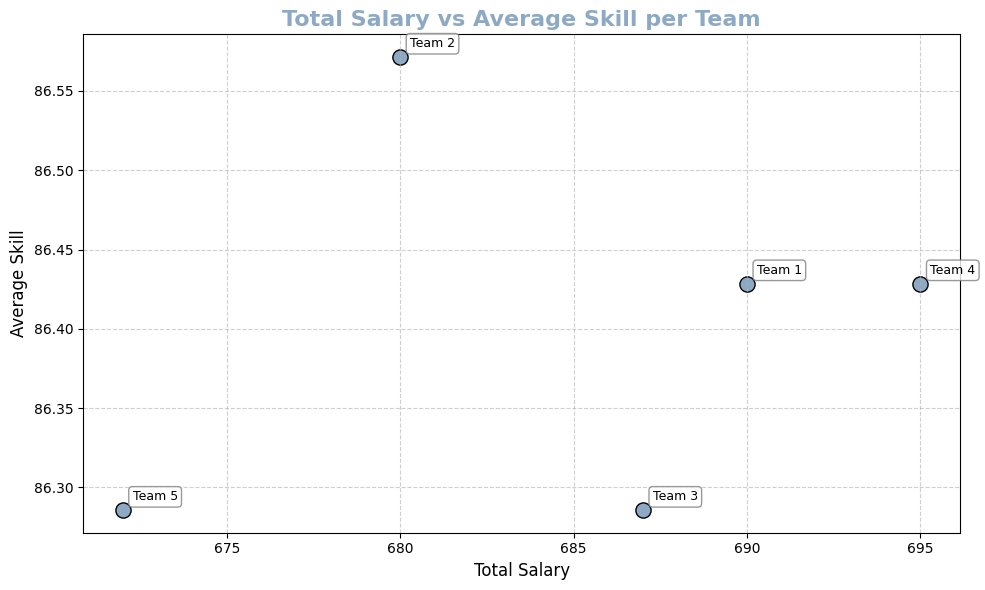

In [ ]:
import matplotlib.pyplot as plt

# Extract necessary data from the best solution's teams
total_salaries = [team.total_salary() for team in best_solution[0].teams]
average_skills = [team.average_skill() for team in best_solution[0].teams]
team_labels = [f"Team {i+1}" for i in range(len(best_solution[0].teams))]

# Define your custom color
custom_color = '#8DA9C4'

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot with styled points
plt.scatter(
    total_salaries,
    average_skills,
    color=custom_color,         # Custom color for your brand
    s=120,                      # Larger point size
    edgecolor='black',         # Black edge for better contrast
    linewidth=1
)

# Annotate each point with its team label
for i, label in enumerate(team_labels):
    plt.annotate(
        label,
        (total_salaries[i], average_skills[i]),
        textcoords="offset points",
        xytext=(7, 7),           # Text offset
        ha='left',
        fontsize=9,
        bbox=dict(
            boxstyle="round,pad=0.3",
            edgecolor="gray",
            facecolor="white",
            alpha=0.8            # Slight transparency for a modern look
        )
    )

# Set titles and labels with enhanced formatting
plt.title('Total Salary vs Average Skill per Team', fontsize=16, fontweight='bold', color=custom_color)
plt.xlabel('Total Salary', fontsize=12)
plt.ylabel('Average Skill', fontsize=12)

# Add a clean grid
plt.grid(True, linestyle='--', alpha=0.6)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
# Initial function used to plot, but was unused in final notebook

def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    handles, labels = [], []

    for config_name, df in fitness_dfs.items():
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)
        
        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    # Shared boxed legend below
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        borderpad=1
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

In [ ]:
# This function takes a list of keywords, runs throught the fitness_dfs, and creates an average of all runs that used that parameter
# This was used to see the the fitness curve of certain configurations, but here it shows how all configurations performes very similar

def plot_matching_configs(fitness_dfs, keywords, show_legend=True, use_median=False, show_std=False):

    matched = {
        name: df for name, df in fitness_dfs.items()
        if all(keyword in name for keyword in keywords)
    }

    if not matched:
        print("No configurations matched the given keywords.")
        return

    plt.figure(figsize=(12, 6))

    for name, df in matched.items():
        x = df.columns
        central_tendency = df.median(axis=0) if use_median else df.mean(axis=0)

        plt.plot(x, central_tendency.values, label=name)

        if show_std and not use_median:
            std_dev = df.std(axis=0)
            plt.fill_between(x, 
                             central_tendency - std_dev,
                             central_tendency + std_dev,
                             alpha=0.2)

    label = "Median" if use_median else "Mean"
    plt.title(f"{label} Fitness Across Generations\nMatching: {', '.join(keywords)}")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    if show_legend:
        plt.legend()
    plt.grid(True)
    plt.xticks(range(0, df.shape[1], 10))  # Show every 10 generations
    plt.tight_layout()
    plt.show()



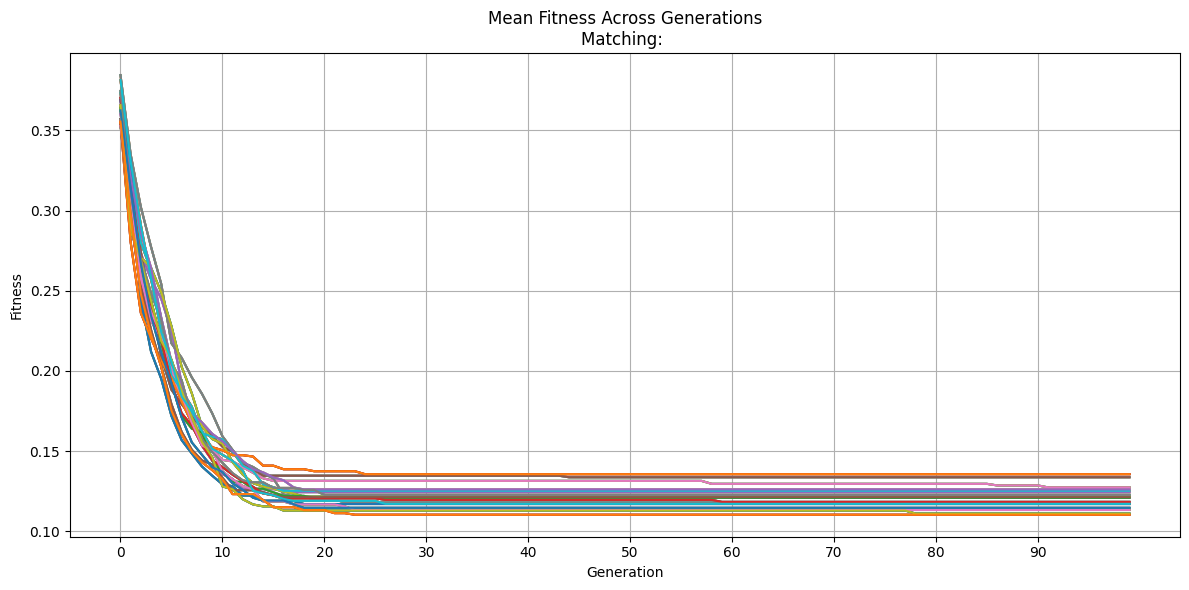

In [ ]:
plot_matching_configs(fitness_dfs, [], show_legend=False)

In [ ]:
# The following blocks of code are used ot fix a certain parameter, and see how it compares to others. XXX_names are the parameters being fixed when calculating the averages

crossover_names = ["cycle_crossover0.2", "cycle_crossover0.9", "swap_crossover0.2", "swap_crossover0.9"]
mutation_names = ["swap_mutation0.1", "swap_mutation0.5", "invertion_mutation0.1", "invertion_mutation0.5", "shift_mutation0.1", "shift_mutation0.5"]
selection_names = ["fitness_proportionate_selection", "tournament_selection(k=3)", "tournament_selection(k=6)"]
elitism_names = ["True"]

crossover_fit_dfs = {}
mutation_fit_dfs = {}
selection_fit_dfs = {}
elitism_fit_dfs = {}

# Combine all runs using a given crossover
for crossover_name in crossover_names:
    dfs_to_concat = [df for name, df in fitness_dfs.items() if crossover_name in name]
    if dfs_to_concat:
        crossover_fit_dfs[crossover_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)

# Combine all runs using a given mutation
for mutation_name in mutation_names:
    dfs_to_concat = [df for name, df in fitness_dfs.items() if mutation_name in name]
    if dfs_to_concat:
        mutation_fit_dfs[mutation_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)

# Combine all runs using a given selection
for selection_name in selection_names:
    dfs_to_concat = [df for name, df in fitness_dfs.items() if selection_name in name]
    if dfs_to_concat:
        selection_fit_dfs[selection_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)

# Combine all runs using a given elitism value (only "True")
for elitism_name in elitism_names:
    dfs_to_concat = [df for name, df in fitness_dfs.items() if f"elitism={elitism_name}" in name]
    if dfs_to_concat:
        elitism_fit_dfs[elitism_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)


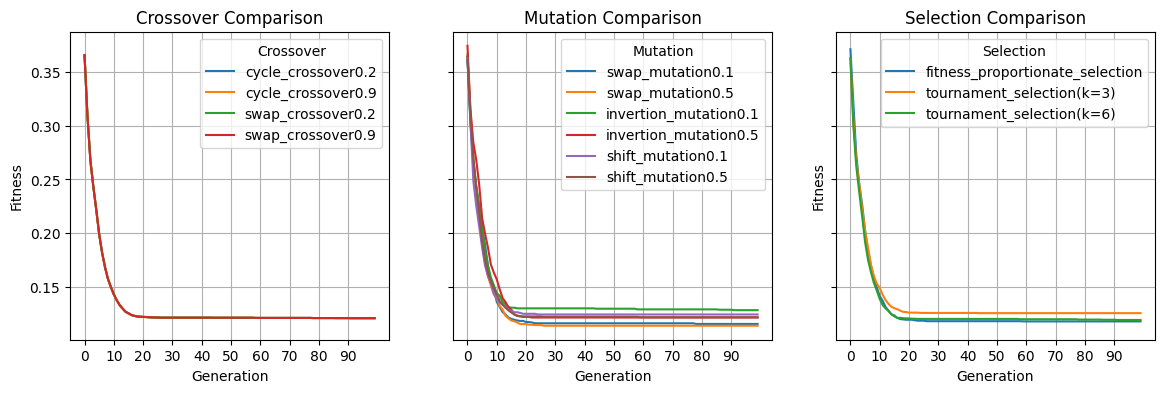

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

# Plot crossover results
for name, df in crossover_fit_dfs.items():
    mean_fitness = df.mean(axis=0)
    axes[0].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[0].set_title("Crossover Comparison")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("Fitness")
axes[0].set_xticks(range(0, df.shape[1], 10))
axes[0].legend(title="Crossover")
axes[0].grid(True)

# Plot mutation results
for name, df in mutation_fit_dfs.items():
    mean_fitness = df.mean(axis=0)
    axes[1].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[1].set_title("Mutation Comparison")
axes[1].set_xlabel("Generation")
axes[1].set_xticks(range(0, df.shape[1], 10))
axes[1].legend(title="Mutation")
axes[1].grid(True)

# Plot selection results
for name, df in selection_fit_dfs.items():
    mean_fitness = df.mean(axis=0)
    axes[2].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[2].set_title("Selection Comparison")
axes[2].set_xlabel("Generation")
axes[2].set_ylabel("Fitness")
axes[2].set_xticks(range(0, df.shape[1], 10))
axes[2].legend(title="Selection")
axes[2].grid(True)





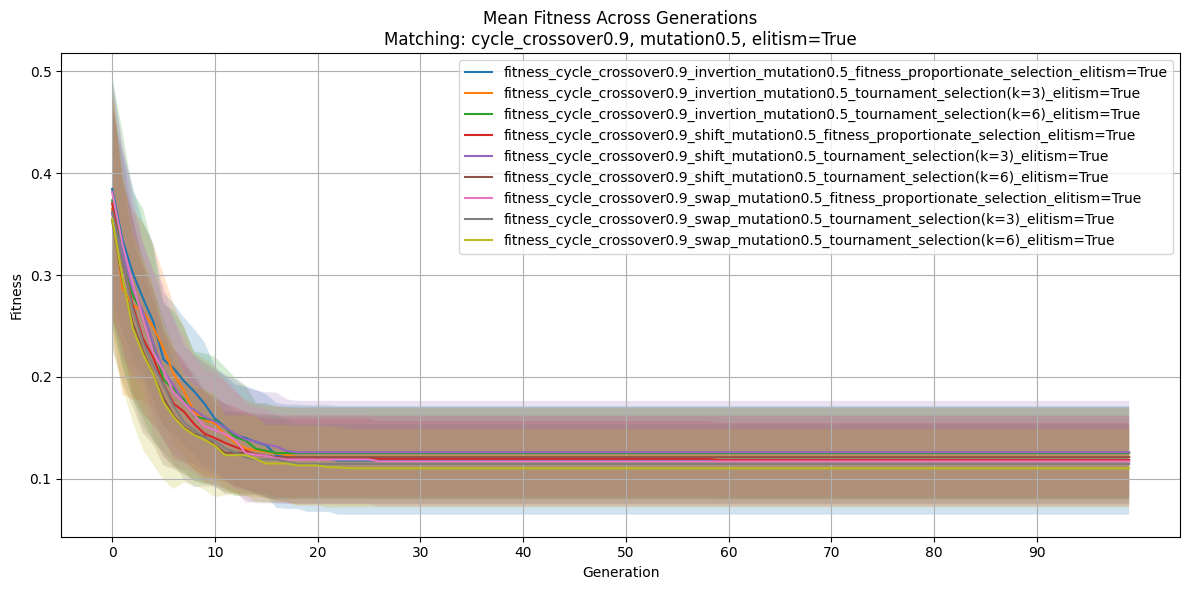

In [ ]:
# The fitness curves, despite similar, could have different standard deviations indicating if a certain configuration is better than another. 
# The following plot shows that all lines fall within one standard deviation of eachother, meaning that they are not statistically different

plot_matching_configs(fitness_dfs, ["cycle_crossover0.9", "mutation0.5", "elitism=True"], show_std=True)

In [ ]:
# To confirm that there is no difference between different configuration perfomances, the following function creates a df that performs the wilcoxon non parametric test
# The resulting df shows the two used configurations, and their p-value with a significance level of 95%.
# At the end, it is shown that no pair is statistically different 

def wilcoxon_final_gen_tests_simple(fitness_dfs, alpha=0.05, correction_method="bonferroni"):
    # Extract last generation fitness values for each config
    last_gen_fitness = {
        label: df.iloc[:, -1].values  # last column = final generation fitness values (30 runs)
        for label, df in fitness_dfs.items()
    }

    results = []
    labels = list(last_gen_fitness.keys())

    for a, b in combinations(labels, 2):
        stat, p = wilcoxon(last_gen_fitness[a], last_gen_fitness[b])
        results.append((a, b, stat, p))

    # Convert results to DataFrame
    wilcoxon_df = pd.DataFrame(results, columns=["Config A", "Config B", "Statistic", "P-Value"])

    # Adjust p-values for multiple comparisons
    pvals = wilcoxon_df["P-Value"].values
    _, pvals_adj, _, _ = multipletests(pvals, alpha=alpha, method=correction_method)
    wilcoxon_df["P-Adj"] = pvals_adj

    # Flag significant results after correction
    wilcoxon_df["Significant"] = wilcoxon_df["P-Adj"] < alpha

    return wilcoxon_df



In [ ]:

pvals_df = wilcoxon_final_gen_tests_simple(fitness_dfs)


c:\Users\USER\anaconda3\envs\NEL_2025\Lib\site-packages\scipy\stats\_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


Number of statistically significant dissimilar pairs of configurations: 0


In [ ]:
print(f"Number of statistically significant dissimilar pairs of configurations: {pvals_df["Significant"].sum()}")

Number of statistically significant dissimilar pairs of configurations: 0


# Running a final GA

Seeing as there are no significantly different configurations, any configuration can be chosen for the final GA. This is to provide a final solution to the problem.

Best solution: (<__main__.League object at 0x000001BD597995B0>, [0.3964124835860459, 0.3964124835860459, 0.3410667538946623, 0.3410667538946623, 0.27479120088101655, 0.27479120088101655, 0.27479120088101655, 0.27479120088101655, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.18626292586292753, 0.18626292586292753, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.1195228609334

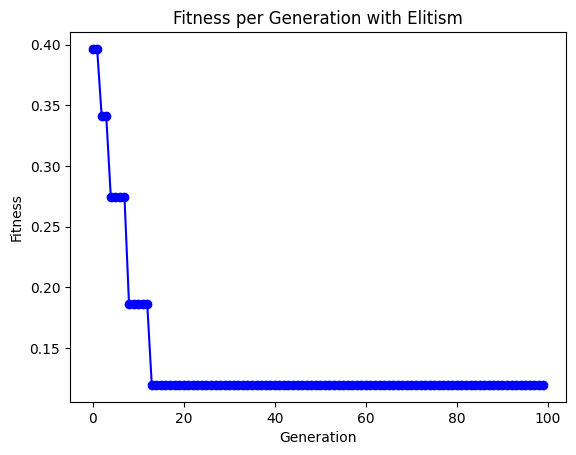

In [ ]:
SEED = 10
random.seed(SEED)
np.random.seed(SEED)

POP_SIZE = 50
initial_population = []


for _ in range(POP_SIZE):
    players = [Player(row) for _, row in players_df.iterrows()]
    league = League(swap_crossover, swap_mutation)
    league.draft_players(players)
    initial_population.append(league)

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=100,
    selection_algorithm=fitness_proportionate_selection,
    maximization=False,
    mut_prob=0.4,
    verbose=False,
    elitism=True
)

print("Best solution:", best_solution)
print("Fitness:", best_solution[0].fitness())
print("Fitness List:", best_solution[1])


# Create a line plot
plt.plot(best_solution[1], marker='o', linestyle='-', color='b')

# Optional: Add labels and title
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness per Generation with Elitism')

# Show the plot
plt.show()

In [ ]:
best_solution[0].show_teams()


Team 1
──────────────
Alex Carter - GK
Mason Reed - DEF
Daniel Foster - DEF
Ashton Phillips - MID
Nathan Wright - MID
Zachary Nelson - FWD
Tyler Jenkins - FWD

Team 2
──────────────
Blake Henderson - GK
Jaxon Griffin - DEF
Ethan Howard - DEF
Dominic Bell - MID
Bentley Rivera - MID
Elijah Sanders - FWD
Julian Scott - FWD

Team 3
──────────────
Chris Thompson - GK
Logan Brooks - DEF
Brayden Hughes - DEF
Dylan Morgan - MID
Spencer Ward - MID
Chase Murphy - FWD
Xavier Bryant - FWD

Team 4
──────────────
Ryan Mitchell - GK
Caleb Fisher - DEF
Lucas Bennett - DEF
Hunter Cooper - MID
Gavin Richardson - MID
Landon Powell - FWD
Sebastian Perry - FWD

Team 5
──────────────
Jordan Smith - GK
Maxwell Flores - DEF
Owen Parker - DEF
Austin Torres - MID
Connor Hayes - MID
Adrian Collins - FWD
Colton Gray - FWD
──────────────
